In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [5]:
file = np.load("/Users/garrettbrown/Desktop/CS189/HWs/hw3/data/mnist-data-hw3.npz")
training_data = file["training_data"]
training_labels = file["training_labels"]
training_data = training_data.astype(float)
N, D = (training_data.shape[0], training_data.shape[2] * training_data.shape[3])
training_data = np.resize(training_data, (N, D))

#normalize each digit
for i in range(N):
    training_data[i,:] = training_data[i,:] / np.linalg.norm(training_data[i,:])

In [7]:
#split data into training and validation

#first shuffle the data
indices = np.arange(N)
np.random.shuffle(indices)
training_data = training_data[indices]
training_labels = training_labels[indices]
training_share = int(((5/6) * N))

#use the last 1/6 as validation
valid_data = training_data[training_share:, :]
valid_labels = training_labels[training_share:]
training_data = training_data[:training_share, :]
training_labels = training_labels[:training_share]

In [9]:
#train the LDA/QDA on different training batch sizes
#"training" LDA/QDA just means compute the class means and (pooled) covariances for training data

batch_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
batches = len(batch_sizes)
batch_means = []
batch_covs = []
batch_pooled_covs = []
batch_props = []

for batch_size in batch_sizes:
    indices = np.arange(training_share)
    np.random.shuffle(indices)
    batch_data = training_data[indices][:batch_size, :]
    batch_labels = training_labels[indices][:batch_size]

    #separate data by label in order to compute the sample mean and sample cov of each class
    indices = np.argsort(batch_labels)
    batch_labels = batch_labels[indices]
    batch_data = batch_data[indices, :]

    label_inds = [0]
    cur = 0
    ind = 0
    for i in range(10):
        while ind < batch_size and batch_labels[ind] == batch_labels[cur]:
            ind += 1
        label_inds.append(ind)
        cur = ind

    #create sample mean vector for each class
    means = []
    for i in range(10):
        means.append(np.mean(batch_data[label_inds[i]:label_inds[i + 1],:], 0))
    means = np.array(means)
    batch_means.append(means)

    #create sample covariance matrix for each class (for QDA)
    covs = []
    for i in range(10):
        covs.append(np.cov(batch_data[label_inds[i]:label_inds[i + 1],:], rowvar = False))
    batch_covs.append(covs)

    #pooled covariance for LDA
    pooled_cov = 0
    for i in range(10):
        pooled_cov += covs[i]
    pooled_cov = (1/10 * pooled_cov)
    batch_pooled_covs.append(pooled_cov)
    
    #we record the proportion of the total data in each class, to be used in LDA
    props = []
    for i in range(10):
        props.append((label_inds[i + 1] - label_inds[i]) / batch_size)
    batch_props.append(props)

In [11]:
#write a function that returns LDA label of data points

#we need to maximize the linear discriminant function:
#data should be given as a batch of 1d vectors of length 784 (i.e. (N, 784))
#returns the labels that maximizes the linear discriminant function for each data point

def LDA(data, batch_num):
    pooled_covs = batch_pooled_covs[batch_num]
    means = batch_means[batch_num]
    props = batch_props[batch_num]
    
    #some helper computations
    second_terms = []
    for i in range(10):
        helper = np.linalg.lstsq(pooled_covs, means[i], 
                                 rcond = None)[0]
        second_terms.append(-1/2 * np.dot(means[i], helper)
                            + math.log(props[i]))
    second_terms = np.array(second_terms)

    #compute LDFs and take the maximizing label
    n = data.shape[0]
    mu_covs = []
    for i in range(10):
        mu_covs.append(np.linalg.lstsq(pooled_covs, means[i], rcond = None)[0])
    mu_covs = np.array(mu_covs)  

    LDFs = []
    for i in range(n):
        new = []
        for j in range(10):
            new.append(np.dot(mu_covs[j], data[i]) + second_terms[j])
        LDFs.append(new)
    LDFs = np.array(LDFs)
    
    return np.argmax(LDFs, axis = 1)

In [13]:
#write a function that returns QDA label of data points

#we need to maximize the quadratic discriminant function:
#data should be given as a batch of 1d vectors of length 784 (i.e. (N, 784))
#returns the labels that maximizes the quadratic discriminant function for each data point
#this will use batch_covs since we do not assume that every class has the same covariance.

def QDA(data, batch_num):
    means = batch_means[batch_num]
    covs = batch_covs[batch_num]
    props = batch_props[batch_num]

    # Regularize covariances and precompute Cholesky decompositions
    cholesky_factors = []
    for i in range(10):
        covs[i] += 1e-3 * np.eye(covs[i].shape[0])
        cholesky_factors.append(np.linalg.cholesky(covs[i]))
    
    #some helper computations
    second_terms = np.empty(10)
    for i in range(10):
        second_terms[i] = (-1/2 * np.linalg.slogdet(covs[i])[1]) + math.log(props[i])

    #compute QDFs and take the maximizing label
    n = data.shape[0]
    labels = np.empty(n, dtype = int)
    for i in range(n):
        QDFs = np.empty(10)
        for j in range(10):
            x_mean = data[i] - means[j]

            L = cholesky_factors[j]
            y = np.linalg.solve(L, x_mean)
            cov_x_mean = np.linalg.solve(L.T, y)

            QDFs[j] = -0.5 * np.dot(x_mean, cov_x_mean) + second_terms[j]
        labels[i] = np.argmax(QDFs)
    return labels

In [15]:
#at this point we have the trained parameters for each batch
#and LDA function that acts on each batch
#we iterate each batch and compute the validation error

valid_size = 10000 #must be <= 10000, size of validation set
valid_data = valid_data[:valid_size, :]
valid_labels = valid_labels[:valid_size]
LDA_total_valid_errors = []
LDA_digit_valid_errors = []

#first sort the validation by label so that we can determine the validation accuracy on each digit
indices = np.argsort(valid_labels)
valid_labels = valid_labels[indices]
valid_data = valid_data[indices, :]

#have the index buckets of each label
label_inds = [0]
cur = 0
ind = 0
for i in range(10):
    while ind < valid_size and valid_labels[ind] == valid_labels[cur]:
        ind += 1
    label_inds.append(ind)
    cur = ind

In [9]:
#compute the total LDA validation error and the error for each digit, for each batch. Show the total validation error

for batch_num in range(batches):
    LDA_labels = LDA(valid_data, batch_num)
    
    digit_errors = []
    for i in range(10):
        digit_errors.append( np.sum(LDA_labels[label_inds[i]:label_inds[i + 1]] != i) / (label_inds[i + 1] - label_inds[i]))
    LDA_digit_valid_errors.append(digit_errors)
    
    LDA_total_valid_errors.append(np.sum(LDA_labels
                                    != valid_labels) / valid_size)
    
print(f"LDA total validation errors in order from smallest to largest training batch size:{LDA_total_valid_errors}")
LDA_total_valid_errors = np.array(LDA_total_valid_errors)
LDA_digit_valid_errors = np.array(LDA_digit_valid_errors)

LDA total validation errors in order from smallest to largest training batch size:[0.343, 0.2833, 0.655, 0.329, 0.1953, 0.1561, 0.135, 0.1283, 0.1249]


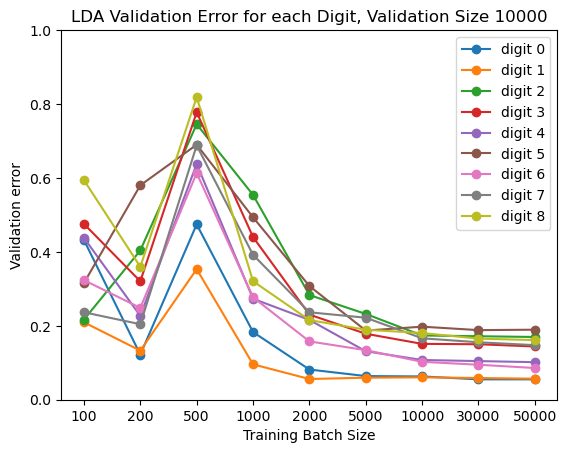

In [18]:
#visualizing the LDA validation error on each individual digit

for i in range(9):
    x = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    y = LDA_digit_valid_errors[:, i]
    plt.plot(x, y, marker='o', linestyle='-', label=f'digit {i}')

plt.title(f'LDA Validation Error for each Digit, Validation Size {valid_size}')
plt.xlabel('Training Batch Size')
plt.xticks(ticks=x, labels=batch_sizes)
plt.ylabel('Validation error')
plt.ylim(0, 1)
plt.legend()

In [8]:
#compute the total QDA validation error and the error for each digit, for each batch

QDA_total_valid_errors = []
QDA_digit_valid_errors = []

for batch_num in range(batches):
    QDA_labels = QDA(valid_data, batch_num)

    digit_errors = []
    for i in range(10):
        digit_errors.append( np.sum(QDA_labels[label_inds[i]:label_inds[i + 1]] != i) / (label_inds[i + 1] - label_inds[i]))
    QDA_digit_valid_errors.append(digit_errors)
    
    QDA_total_valid_errors.append(np.sum(QDA_labels
                                    != valid_labels) / valid_size)
    print(batch_num)
    print(digit_errors)
    
print("FINAL")
print(QDA_total_valid_errors)
QDA_total_valid_errors = np.array(QDA_total_valid_errors)
QDA_digit_valid_errors = np.array(QDA_digit_valid_errors)

0
[0.25, 0.09090909090909091, 0.0, 0.3076923076923077, 0.1111111111111111, 0.5714285714285714, 0.15384615384615385, 0.42857142857142855, 0.16666666666666666, 0.38461538461538464]
1
[0.0, 0.09090909090909091, 0.0, 0.23076923076923078, 0.3333333333333333, 0.42857142857142855, 0.23076923076923078, 0.42857142857142855, 0.3333333333333333, 0.07692307692307693]
2
[0.0, 0.09090909090909091, 0.0, 0.07692307692307693, 0.0, 0.5714285714285714, 0.23076923076923078, 0.2857142857142857, 0.08333333333333333, 0.07692307692307693]
3
[0.0, 0.09090909090909091, 0.0, 0.0, 0.0, 0.42857142857142855, 0.0, 0.2857142857142857, 0.08333333333333333, 0.0]
4
[0.0, 0.09090909090909091, 0.0, 0.07692307692307693, 0.0, 0.2857142857142857, 0.15384615384615385, 0.14285714285714285, 0.08333333333333333, 0.07692307692307693]
5
[0.0, 0.09090909090909091, 0.0, 0.07692307692307693, 0.0, 0.2857142857142857, 0.15384615384615385, 0.2857142857142857, 0.08333333333333333, 0.0]
6
[0.0, 0.09090909090909091, 0.0, 0.0769230769230769